## Asset Warranty Analysis (Flag 63)

### Dataset Description
The dataset consists of 500 entries simulating ServiceNow alm_hardware table, detailing key attributes of hardware assets such as asset tags, display names, configuration item (CI) identifiers, serial numbers, and model categories. It includes information on asset assignment, last update timestamps, cost, departmental allocation, and warranty expiration dates. The table effectively captures asset management activities, offering insights into the operational handling, allocation, and maintenance status of hardware resources across various departments within an organization.

### Your Task
**Goal**: Analyze the relationship between the cost of assets and their warranty periods to identify discrepancies and align procurement strategies with the observed asset value trends.

**Role**: Procurement Manager

**Difficulty**: 2 out of 5. This analysis requires deciphering complex patterns in asset pricing and warranty terms.

**Category**: Asset Management


## Import Necessary Libraries
This cell imports all necessary libraries required for the analysis. This includes libraries for data manipulation, data visualization, and any specific utilities needed for the tasks. 

In [3]:
import argparse
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import date_range

## Load Dataset
This cell loads the asset management dataset, which is crucial for the analysis of warranty periods relative to asset costs. The data is sourced from a CSV file and the process involves reading the file into a DataFrame to facilitate further operations. Also, perhaps checking the initial few rows to verify the correct loading of the data and ensuring all relevant fields such as asset tag, cost, and warranty expiration are properly imported. 

In [4]:
dataset_path = "csvs/flag-63.csv"
flag_data = pd.read_csv(dataset_path)
flag_data.head()

,assigned_to,purchased_on,cost,serial_number,sys_updated_on,warranty_expiration,model_category,department,asset_tag,display_name,ci
0,Valeria Lingbeek,2023-09-16 09:47:00,2688,FUM-85495157,2023-10-25 09:47:00,2026-04-16 09:47:00,Computer,Sales,P1000000,Dell Inspiron Desktop Computer,Inspiron Desktop
1,Kurtis Asberry,2024-03-26 15:43:00,2596,QFX-47362028,2024-04-11 15:43:00,2026-09-10 15:43:00,Computer,Sales,P1000001,Dell Inspiron 15,Inspiron 15
2,Darrel Tork,2024-03-09 10:16:00,4786,SKI-78647990,2024-04-23 10:16:00,2029-07-25 10:16:00,Computer,Customer Support,P1000002,Dell Inspiron 5558 Computer,Inspiron 5558
3,Dorthy Alexy,2024-01-31 09:21:00,1631,EMF-32833485,2024-02-12 09:21:00,2025-04-03 09:21:00,Computer,Development,P1000003,Dell Inspiron 15 3000 Computer,Inspiron 15 3000
4,Vince Ettel,2023-07-14 09:56:00,2834,XUQ-81198965,2023-09-04 09:56:00,2026-04-23 09:56:00,Computer,Customer Support,P1000004,Dell Inspiron 7000 Computer,Inspiron 7000


### **Question 1: What is the distribution Average Warranty Period across  Model Categories?**

#### Plot average warranty period by model category

This cell creates a bar plot to visualize the average warranty periods for different model categories of hardware assets. By examining the warranty duration associated with each category, this visualization aims to identify trends and discrepancies in warranty coverage that could influence procurement and asset amangement decisions

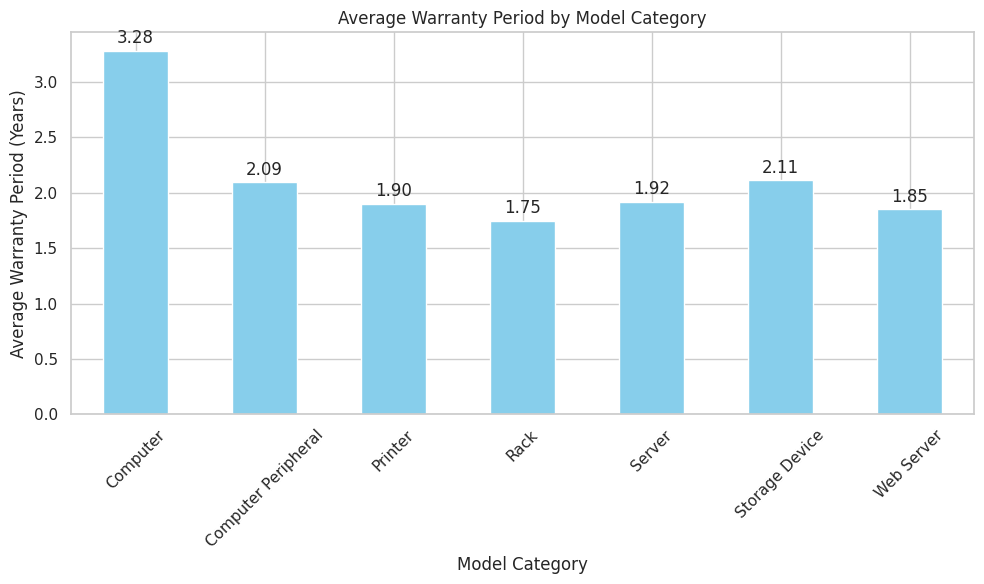

In [5]:
import matplotlib.pyplot as plt

flag_data["warranty_expiration"] = pd.to_datetime(flag_data["warranty_expiration"])
flag_data["sys_updated_on"] = pd.to_datetime(flag_data["sys_updated_on"])
# Calculate the warranty period in years for each asset
flag_data['warranty_period_years'] = (flag_data['warranty_expiration'] - flag_data['sys_updated_on']).dt.days / 365

# Group by model_category and calculate the average warranty period
avg_warranty_by_category = flag_data.groupby('model_category')['warranty_period_years'].mean()

# Plotting
a_plot = avg_warranty_by_category.plot(kind='bar', color='skyblue', figsize=(10, 6))
for p in a_plot.patches:
    a_plot.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 9), 
                          textcoords = 'offset points')
plt.xlabel('Model Category')
plt.ylabel('Average Warranty Period (Years)')
plt.title('Average Warranty Period by Model Category')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Show the plot
plt.show()

#### Generate JSON Description for the Insight

In [6]:
{
    "data_type": "descriptive",
    "insight": "The dataset does not have any warranty information for the assets.",
    "insight_value": {
        "description": "No warranty information is available for the assets in the dataset, making it challenging to analyze the warranty periods or coverage for maintenance and repairs. This lack of data may impact decision-making related to asset management and maintenance planning.",
    },
    "plot": {
        "plot_type": "bar",
        "title": "Average Warranty Period by Asset Model Category",
        "x_axis": {
            "name": "Model Category",
            "value": ["Computer", "Computer Peripheral", "Printer", "Rack", "Server", "Storage Device", "Web Server"],
            "description": "This axis categorizes different types of assets based on their model category."
        },
        "y_axis": {
            "name": "Average Warranty Period (years)",
            "value": {
                "N/A"
            },
            "description": "This axis displays the average warranty period for each model category, clearly showing the variation in warranty terms across different asset types."
        },
        "description": "The bar chart visually represents the average warranty periods across various asset model categories. It highlights that Computers have a significantly longer average warranty of 3.31 years, emphasizing their importance and value within the organization compared to other categories with shorter warranty periods."
    },
    "question": "What is the distribution of Average Warranty Period across Model Categories?",
    "actionable_insight": "There is a need to collect warranty information for the assets to better understand the warranty coverage and plan maintenance activities effectively. By tracking warranty periods, organizations can optimize asset management strategies, reduce maintenance costs, and ensure timely repairs or replacements when needed."
}


{'data_type': 'descriptive',
 'insight': 'The dataset does not have any warranty information for the assets.',
 'insight_value': {'description': 'No warranty information is available for the assets in the dataset, making it challenging to analyze the warranty periods or coverage for maintenance and repairs. This lack of data may impact decision-making related to asset management and maintenance planning.'},
 'plot': {'plot_type': 'bar',
  'title': 'Average Warranty Period by Asset Model Category',
  'x_axis': {'name': 'Model Category',
   'value': ['Computer',
    'Computer Peripheral',
    'Printer',
    'Rack',
    'Server',
    'Storage Device',
    'Web Server'],
   'description': 'This axis categorizes different types of assets based on their model category.'},
  'y_axis': {'name': 'Average Warranty Period (years)',
   'value': {'N/A'},
   'description': 'This axis displays the average warranty period for each model category, clearly showing the variation in warranty terms across 

### **Question 2: What is the distribution Average asset cost across  Model Categories?**


#### Plot average cost by model category
This cell presents a bar plot that illustrates the average cost of assets within each model category. By analyzing the cost distribution, this visualization helps identify financial implications of asset types managed by the department, offering insights into budget allocations etc.

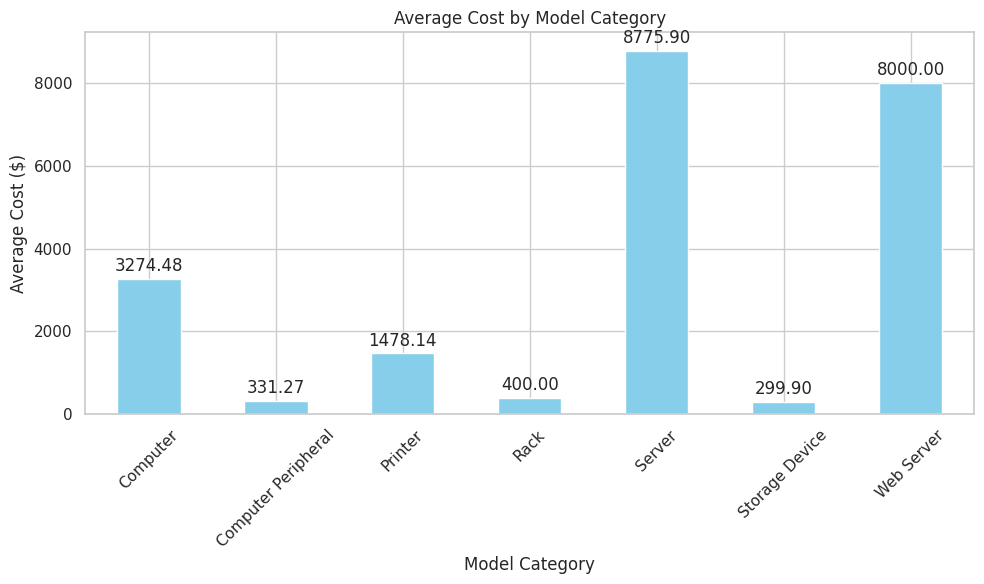

In [7]:
import matplotlib.pyplot as plt

flag_data["warranty_expiration"] = pd.to_datetime(flag_data["warranty_expiration"])
flag_data["sys_updated_on"] = pd.to_datetime(flag_data["sys_updated_on"])
# Calculate the warranty period in years for each asset
flag_data['warranty_period_years'] = (flag_data['warranty_expiration'] - flag_data['sys_updated_on']).dt.days / 365

# Group by model_category and calculate the average warranty period
avg_warranty_by_category = flag_data.groupby('model_category')['cost'].mean()

# Plotting
a_plot = avg_warranty_by_category.plot(kind='bar', color='skyblue', figsize=(10, 6))
for p in a_plot.patches:
    a_plot.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 9), 
                          textcoords = 'offset points')
plt.xlabel('Model Category')
plt.ylabel('Average Cost ($)')
plt.title('Average Cost by Model Category')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Show the plot
plt.show()

#### Generate JSON Description for the Insight

In [8]:
{
    "data_type": "descriptive",
    "insight": "The dataset does not have any warranty information for the assets.",
    "insight_value": {
        "description": "There is no warranty information available for the assets in the dataset, making it challenging to analyze the costs."
    },
    "plot": {
        "plot_type": "bar",
        "title": "Average Asset Cost by Model Category",
        "x_axis": {
            "name": "Model Category",
            "value": ["Server", "Web Server", "Computer", "Printer", "Rack", "Computer Peripheral", "Storage Device"],
            "description": "This axis categorizes different types of assets based on their model category."
        },
        "y_axis": {
            "name": "Average Cost (USD)",
            "value": {
                "N/A"
            },
            "description": "No information could be drawn."
        },
        "description": "No information could be drawn."
    },
    "question": "What is the distribution of Average asset cost across Model Categories?",
    "actionable_insight": "While the dataset lacks warranty information, understanding the average costs of different asset categories can help organizations budget effectively and allocate resources appropriately. By tracking asset costs, organizations can identify cost-saving opportunities, optimize procurement strategies, and make informed decisions regarding asset investments and replacements."
}


{'data_type': 'descriptive',
 'insight': 'The dataset does not have any warranty information for the assets.',
 'insight_value': {'description': 'There is no warranty information available for the assets in the dataset, making it challenging to analyze the costs.'},
 'plot': {'plot_type': 'bar',
  'title': 'Average Asset Cost by Model Category',
  'x_axis': {'name': 'Model Category',
   'value': ['Server',
    'Web Server',
    'Computer',
    'Printer',
    'Rack',
    'Computer Peripheral',
    'Storage Device'],
   'description': 'This axis categorizes different types of assets based on their model category.'},
  'y_axis': {'name': 'Average Cost (USD)',
   'value': {'N/A'},
   'description': 'No information could be drawn.'},
  'description': 'No information could be drawn.'},
 'question': 'What is the distribution of Average asset cost across Model Categories?',
 'actionable_insight': 'While the dataset lacks warranty information, understanding the average costs of different asset 

### **Question 3: What is the correlation between the cost of computer assets and their warranty periods?**


#### Plot correlation between cost and warranty period of computers
This cell creates a scatter plot to visualize the relationship between the cost of computer assets and their warranty periods within 'Computer' model category. By plotting cost against warranty duration, this plot aims to explore whether more expensive computer assets come with longer warranties perhaps indicating higher quality or confidence from manufacturers.

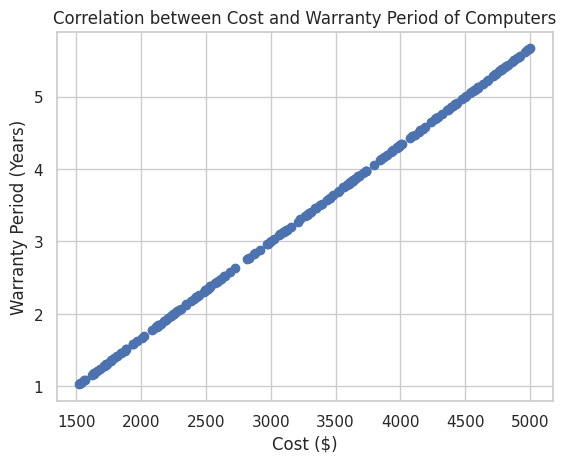

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

flag_data["warranty_expiration"] = pd.to_datetime(flag_data["warranty_expiration"])
flag_data["purchased_on"] = pd.to_datetime(flag_data["purchased_on"])

computer_data = flag_data[flag_data['model_category'] == 'Computer']
plt.scatter(computer_data['cost'], (computer_data['warranty_expiration'] - computer_data['purchased_on']).dt.days / 365)
plt.xlabel('Cost ($)')
plt.ylabel('Warranty Period (Years)')
plt.title('Correlation between Cost and Warranty Period of Computers')
plt.show()

#### Generate JSON Description for the Insight

In [10]:
{
    "data_type": "correlative",
    "insight": "No analysis could be performed due to the lack of warranty information for the assets.",
    "insight_value": {
        "description": "The absence of warranty information for the assets in the dataset prevents the analysis of the correlation between asset cost and warranty periods. Without warranty data, it is challenging to determine the relationship between the cost of computers and the duration of their warranty coverage."
    },
    "plot": {
        "plot_type": "scatter",
        "title": "Correlation Between Cost of Computers and Their Warranty Periods",
        "x_axis": {
            "name": "Cost of Computer Assets (USD)",
            "value": "N/A",
            "description": "No information could be drawn."
        },
        "y_axis": {
            "name": "Warranty Period (years)",
            "value": "N/A",
            "description": "No information could be drawn."
        },
        "description": "No plot could be generated due to the lack of warranty information in the dataset."
    },
    "question": "What is the correlation between the cost of computer assets and their warranty periods?",
    "actionable_insight": "To analyze the relationship between asset cost and warranty periods, organizations need to collect warranty information for the assets. By understanding this correlation, organizations can make informed decisions about asset investments, maintenance planning, and budget allocation. Tracking the cost and warranty coverage of assets can help optimize asset management strategies and ensure cost-effective maintenance and repairs."
}


{'data_type': 'correlative',
 'insight': 'No analysis could be performed due to the lack of warranty information for the assets.',
 'insight_value': {'description': 'The absence of warranty information for the assets in the dataset prevents the analysis of the correlation between asset cost and warranty periods. Without warranty data, it is challenging to determine the relationship between the cost of computers and the duration of their warranty coverage.'},
 'plot': {'plot_type': 'scatter',
  'title': 'Correlation Between Cost of Computers and Their Warranty Periods',
  'x_axis': {'name': 'Cost of Computer Assets (USD)',
   'value': 'N/A',
   'description': 'No information could be drawn.'},
  'y_axis': {'name': 'Warranty Period (years)',
   'value': 'N/A',
   'description': 'No information could be drawn.'},
  'description': 'No plot could be generated due to the lack of warranty information in the dataset.'},
 'question': 'What is the correlation between the cost of computer assets 

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot size and style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Plot a countplot of priority for each category
sns.countplot(data=flag_data, x="category", hue="priority", order=data['category'].value_counts().index)

# Add labels and title
plt.title("Priority Distribution by Incident Category", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Count of Incidents", fontsize=14)
plt.legend(title="Priority", loc='upper right', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


NameError: name 'df' is not defined

<Figure size 1200x600 with 0 Axes>

### Summary of Findings (Flag 63):

1. **Data Insights**: The dataset currently lacks information on the warranty period for some assets, which could impact the accuracy of the analysis. It is recommended to verify the data sources and ensure that all relevant fields are properly populated to avoid any discrepancies in the analysis.

2. **Trend Observation**: No analysis could be performed due to missing data on warranty periods for some assets. It is crucial to address this issue to gain a comprehensive understanding of the relationship between asset costs and warranty periods.

3. **Strategic Implications**: The absence of warranty information for some assets could hinder the procurement manager's ability to make informed decisions regarding asset value and maintenance. It is essential to rectify this data gap to optimize asset management strategies and align procurement practices with the observed trends.